# Hourly Energy Consumption End-to-End Analysis

See [Kaggle Dataset](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption) for details.

See [GitHub](https://www.github.com/bryangoodrich/python-exercises) for full codebase of this and other days.

## Import project libraries

In [44]:
import os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.cluster import KMeans, DBSCAN
from matplotlib.dates import MonthLocator, DateFormatter

# 01 - Data Modeling and Preprocessing

### 0035

On this day we load the provided separate time series files, build a file reader and processor, and use this to ingress and combine the data into a single dataframe for the next few steps.

In [45]:
def reader(fh):
    """ Simple file reader and processor """
    site = os.path.splitext(os.path.basename(fh))[0]
    site = site.split("_")[0]
    names = ["read_dt", "read_mw"]
    df = pd.read_csv(fh, header=0, 
        names=names, parse_dates=['read_dt'])
    df['read_date'] = pd.to_datetime(df['read_dt']).dt.date
    df['read_hour'] = df.read_dt.dt.hour
    df['site'] = site
    return df

In [46]:
data_directory = "../0035/data"
files = os.listdir(data_directory)
dfs = (reader(os.path.join(data_directory, fh)) for fh in files)
combined = pd.concat(dfs, ignore_index=True)
combined.drop("read_dt", axis=1, inplace=True)

src = (combined
    .groupby(['site', 'read_date', 'read_hour'])['read_mw']
    .mean()
    .reset_index()
    .pivot(index=['site', 'read_date'],
        columns="read_hour", values='read_mw'))

src.columns = [f'hour{hour:02}' for hour in src.columns]
src = src.reset_index()
src['read_date'] = pd.to_datetime(src.read_date)
display(src.info())

## If writing to disk for later use
# at = pa.Table(df)
# pq.write_table(at.from_pandas(df), 'data.parquet')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45443 entries, 0 to 45442
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   site       45443 non-null  object        
 1   read_date  45443 non-null  datetime64[ns]
 2   hour00     45424 non-null  float64       
 3   hour01     45431 non-null  float64       
 4   hour02     45349 non-null  float64       
 5   hour03     45305 non-null  float64       
 6   hour04     45430 non-null  float64       
 7   hour05     45431 non-null  float64       
 8   hour06     45431 non-null  float64       
 9   hour07     45431 non-null  float64       
 10  hour08     45431 non-null  float64       
 11  hour09     45431 non-null  float64       
 12  hour10     45431 non-null  float64       
 13  hour11     45431 non-null  float64       
 14  hour12     45431 non-null  float64       
 15  hour13     45431 non-null  float64       
 16  hour14     45430 non-null  float64      

None

# 02 - Data Exploration and Visualization

### 0036

For this day, we want to explore the data visually. Having a background in energy consumption analyics, these are a couple of my go-to approaches to understand usage trends. While this data is at the system level for Duke Energy instead of individual households, the techniques are useful to understand. More on this below.

In [47]:
# parameters
site = 'DEOK'  # Duke Energy
year = 2016

### Processing

Here we take the data in wide format and filter for the given site and year. Then I pull the attributes out as indexes so the values are nothing but the 24 hourly columns. But when comparing across days, we need to normalize for apples-to-apples comparisons. One way to achieve this is to convert each hourly value to the percent consumed in that day. 

The benefit of this approach is you can look at daily variations via the daily totals, but any given day has a certain energy budget consumed. By looking at how much energy was "spent" in any given hour as a percentage, we can determine the timing of consumption events, which are important to utilities for various reasons I won't get into detail here. 

In [48]:
filters = (src.site == site) & (src.read_date.dt.year == year)
df = src[filters].sort_values(by='read_date')
values = df.iloc[:, 1:].set_index("read_date")
percentages = values.div(values.sum(axis=1), axis=0) * 100

### Heat Maps

First we plot the nominal values and see throughout 2016 when Duke Energy electricity was consumed. As is expected, it's highest in summer, but we do see some peak consumption during winter times. This is typically due to electric heating during cold seasons. 

Next, we're looking at the timing of consumption across days, and we see a clear pattern between summer and non-summer days. This is typical for most utilities. While the timing shifts slightly between winter and shoulder months, there is a 2 timing peak, but summer is driven by pure heating loads in the afternoon. 

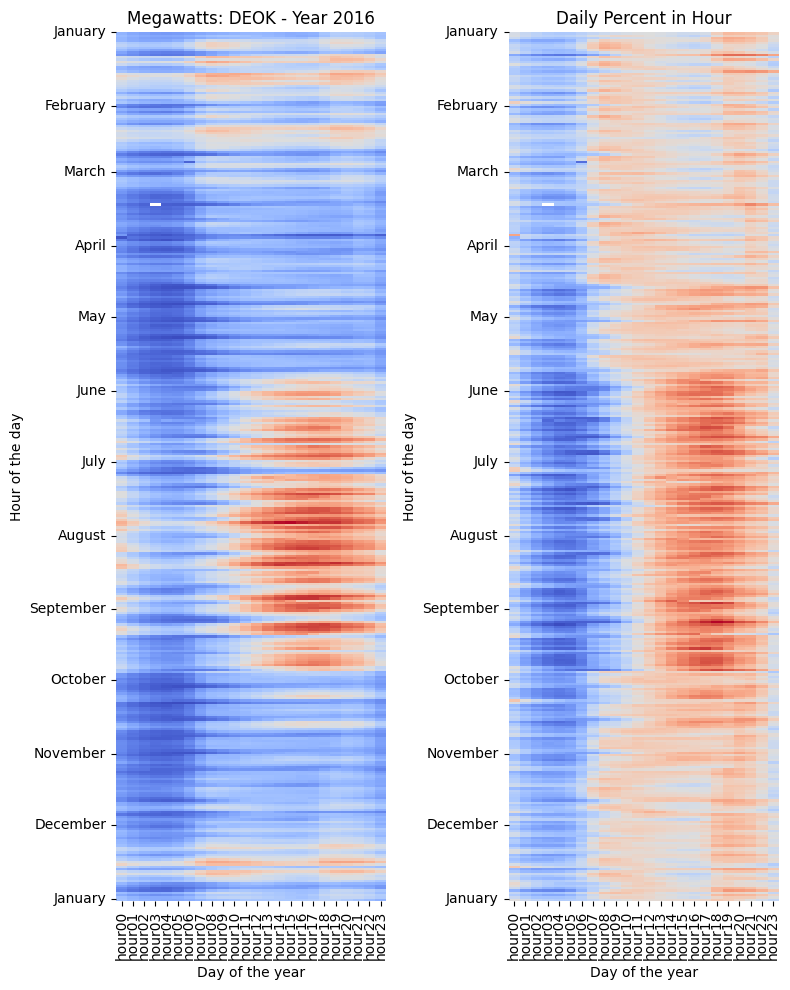

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(8, 10))

sns.heatmap(values, cmap='coolwarm', cbar=False,
    cbar_kws={'shrink': 0.5, 'orientation': 'horizontal'},
    xticklabels=1, yticklabels=1, ax=axes[0])
axes[0].set_title(f'Megawatts: {site} - Year {year}')
axes[0].set_xlabel('Day of the year')
axes[0].set_ylabel('Hour of the day')
month_locator = MonthLocator(bymonthday=1, interval=1)
axes[0].yaxis.set_major_locator(month_locator)
date_format = DateFormatter('%B')
axes[0].yaxis.set_major_formatter(date_format)

sns.heatmap(percentages, cmap='coolwarm', cbar=False,
    cbar_kws={'shrink': 0.5, 'orientation': 'horizontal'},
    xticklabels=1, yticklabels=1, ax=axes[1])
axes[1].set_title(f'Daily Percent in Hour')
axes[1].set_xlabel('Day of the year')
axes[1].set_ylabel('Hour of the day')
month_locator = MonthLocator(bymonthday=1, interval=1)
axes[1].yaxis.set_major_locator(month_locator)
date_format = DateFormatter('%B')
axes[1].yaxis.set_major_formatter(date_format)

plt.tight_layout()
plt.show()

### Percentage Load Profiles or Load Shapes

If we think of the heat map being laid on its side and each row being a line graph, we get the plot below. Essentially we're overlaying each daily loade shape. While not done here, because it didn't turn out as nice, in R I would plot each line as a transparent grey stroke so that where there is significant overlap we can see darkening thickening lines. We would most likely see 2 or 3 patterns we would expect from the trends in the heat map above, and we kind of do see that. 

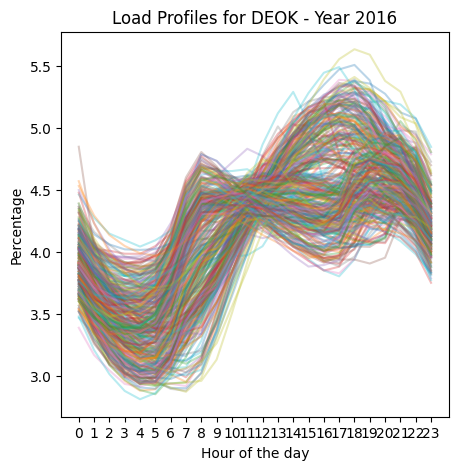

In [50]:
plt.figure(figsize=(5,5))
for date, row in percentages.iterrows():
    plt.plot(range(24), row.values, alpha=0.3)
plt.title(f'Load Profiles for {site} - Year {year}')
plt.xlabel('Hour of the day')
plt.ylabel('Percentage')
plt.xticks(range(24), labels=[str(i) for i in range(24)])
plt.show()

# Machine Learning and Modeling

### 0037

The next step is to see if we can automate, off a subset of the data, some dictionary of load shapes via unsupervised learning or clustering. In the past I've used versions of K-Means for identify centroids that are themselves "typical" load shapes we can then map to any daily load in the past or in the future. By doing this, we can have a catalog of load shapes that have embedded meaning, based on the timing of their consumption events. 

Working with a researcher at Stanford, he came up with a 200 shape dictionary for this purpose. 

Here, and because I'm just looking at one utility instead of a variety of 100,000s of households, we'll just look for a few prototypical shapes! 

In [51]:
# parameters

# Site Options
# 'AEP', 'COMED', 'DAYTON', 'DEOK', 'DOM', 'DUQ',
# 'EKPC', 'FE', 'NI', 'PJM', 'PJME', 'PJMW'
SITE = "DEOK"
SAMPLE_SIZE=1000
STATE = 42
EPS = 0.41
CLUSTERS = 5

### Processing

We access the original source dataframe and process out the given site across years, but take a random sample of daily instances and compute the daily percentages as before. Then we fit both a K-Means and DBSCAN model. Since DBSCAN does not return centroids we can use to represent the model, I take the cluster means as representatives for this purpose.

In [52]:
df = (src
    .query("site == @SITE")
    .dropna()
    .sample(n=SAMPLE_SIZE, random_state=STATE)
    .set_index(['site', 'read_date']))

df = df.div(df.sum(axis=1), axis=0) * 100  # percentages

In [53]:
kmeans = KMeans(n_clusters=CLUSTERS, random_state=STATE).fit(df)
dbscan = DBSCAN(eps=EPS, min_samples=5).fit(df)
centroids = pd.DataFrame(kmeans.cluster_centers_)
means = df.groupby(dbscan.labels_).mean()

/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Visualizations

I plot the overlay graph from before, and the cluster representatives for comparison. There is a lot more that can be done here, to investigate goodness-of-fit, use out-of-sample test data, and evaluate the outliers in DBSCAN, which I've never used in practice, myself. But nevertheless, we do see a consistent picture of Duke Energy!

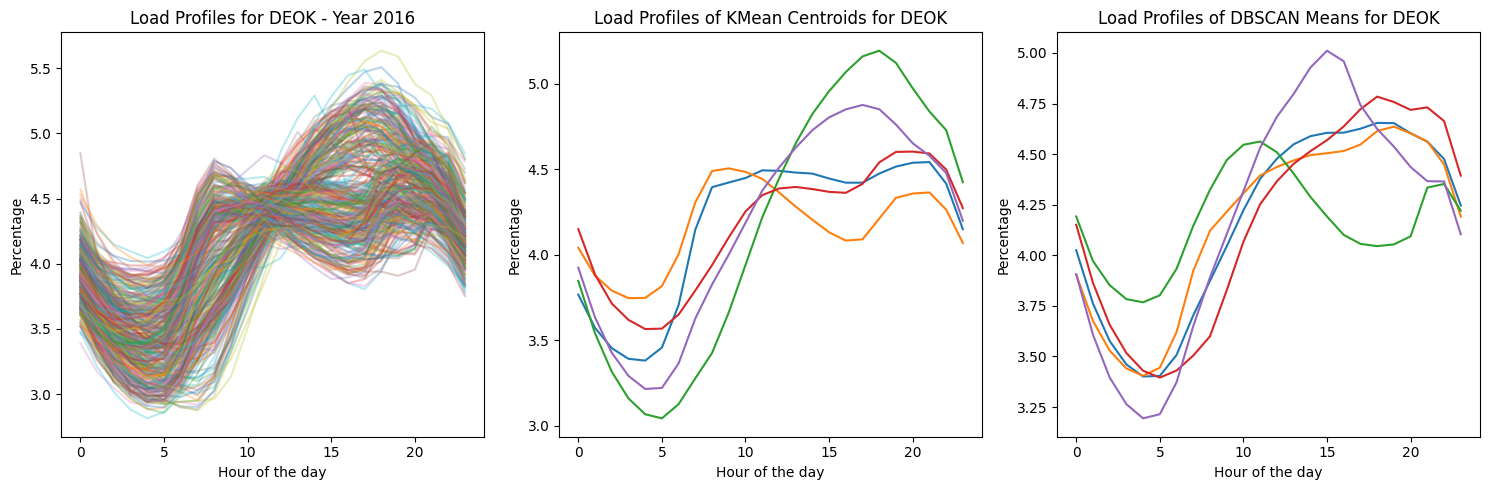

In [54]:
plt.figure(figsize=(15, 5))  # 1x3 Subplots

# OVERLAY
plt.subplot(131)
for date, row in percentages.iterrows():
    plt.plot(range(24), row.values, alpha=0.3)
plt.title(f'Load Profiles for {site} - Year {year}')
plt.xlabel('Hour of the day')
plt.ylabel('Percentage')

# KMEANS
plt.subplot(132)
for _, row in centroids.iterrows():
    plt.plot(range(24), row)
plt.title(f'Load Profiles of KMean Centroids for {SITE}')
plt.xlabel('Hour of the day')
plt.ylabel('Percentage')

# DBSCAN
plt.subplot(133)
for _, row in means.iterrows():
    plt.plot(range(24), row)
plt.title(f'Load Profiles of DBSCAN Means for {SITE}')
plt.xlabel('Hour of the day')
plt.ylabel('Percentage')

plt.tight_layout()
plt.show()


# Statistical Modeling and Day Ahead Forecasting

### 0039

Taking a different turn on this day, we want to explore statistical modeling, and specifically something utilies have to do for purchasing energy is day ahead forecasting. This was an exercise I did years ago when I worked as a data scientist--I'm a data engineer now. Again we look at Duke Energy and this time for the summer of 2012. Instead of the wide-format dataset (hours in columns), we keep things as a simple time series (datetime and megawatts).

In [55]:
names = ["read_dt", "read_mw"]
is_summer = "read_dt >= '2012-05-01' and read_dt < '2012-08-31'"
df = (pd
    .read_csv(f"{data_directory}/{SITE}_hourly.csv", 
        header=0,
        names=names,
        parse_dates=['read_dt'])
    .query(is_summer)
    .sort_values("read_dt")
    .reset_index(drop=True)
)
display(df.head())

,read_dt,read_mw
0,2012-05-01 00:00:00,2671.0
1,2012-05-01 01:00:00,2456.0
2,2012-05-01 02:00:00,2324.0
3,2012-05-01 03:00:00,2254.0
4,2012-05-01 04:00:00,2187.0


In [56]:
ts = df.rename(columns={'read_dt': 'ds', 'read_mw': 'y'})
display(ts.head())

,ds,y
0,2012-05-01 00:00:00,2671.0
1,2012-05-01 01:00:00,2456.0
2,2012-05-01 02:00:00,2324.0
3,2012-05-01 03:00:00,2254.0
4,2012-05-01 04:00:00,2187.0


### Statistical Models

I use the ARIMA function, specifying the 24 hour seasonality. There is a lot more that goes into this analysis, and other seasonality periods to consider. For getting something out quick and dirty, the visuals show it turns out pretty good! 

In [57]:
arima = ARIMA(df.set_index("read_dt"), order=(1,0,1),
    seasonal_order=(1, 0, 0, 24)).fit()
forecasts = arima.forecast(steps=24)

display(forecasts.head())

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


2012-08-31 00:00:00    3303.470112
2012-08-31 01:00:00    3067.738536
2012-08-31 02:00:00    2893.161136
2012-08-31 03:00:00    2772.409085
2012-08-31 04:00:00    2715.242754
Freq: H, Name: predicted_mean, dtype: float64

### Prophet Model

I asked Chappy (Chat-GPT) to give me ideas for this exercise, and he introduced me to Prophet. It was created at Facebook, and I really like how simple it is to feed it a time series (just name your columns ds and y, respectively), and it does the rest. Not only did it come up with an accurate model, it provides you a clean dataframe with the daily and weekly trends, plus confidence intervals. With a little code, it's easy to visualize them to your liking (or just plot the whole dataframe!)

In [58]:
prophet = Prophet()
prophet.fit(ts)
future = prophet.make_future_dataframe(periods=24, freq="H")
pf = prophet.predict(future)

display(pf[["ds", "trend", "daily", "weekly", "yhat"]].head())

20:44:38 - cmdstanpy - INFO - Chain [1] start processing
20:44:38 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,daily,weekly,yhat
0,2012-05-01 00:00:00,3098.695050,-153.769740,140.509463,3085.434772
1,2012-05-01 01:00:00,3097.454209,-425.104049,138.371404,2810.721565
2,2012-05-01 02:00:00,3096.213369,-655.322827,135.572561,2576.463102
3,2012-05-01 03:00:00,3094.972528,-802.724572,132.170413,2424.418370
4,2012-05-01 04:00:00,3093.731688,-859.969972,128.226298,2361.988014


### Exploration

While I didn't go into the deep analyses of identifying lags, nonstationarity, and seasonality frequencies (ugh), I did at least want to show how easy it is to look at the ACF or PACF (the one plottd here) graphs. There are models for these you can use to look at the data directly, but again, quick and dirty. I add the 24 hour lags for the last 3 days which nearly align to the 24 hour frequency I would expect and used in the ARIMA model.

<Figure size 1200x600 with 0 Axes>

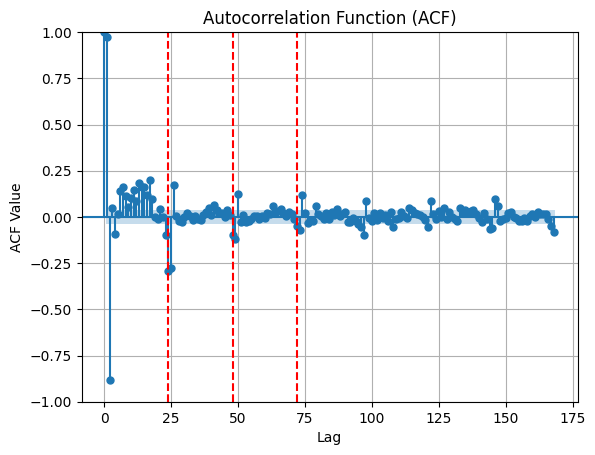

In [59]:
plt.figure(figsize=(12, 6))
plot_pacf(df.read_mw, lags=7*24)
plt.axvline(x=24, color='red', linestyle='--')
plt.axvline(x=24*2, color='red', linestyle='--')
plt.axvline(x=24*3, color='red', linestyle='--')
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('ACF Value')
plt.grid()
plt.show()

### Forecasts

As we see below, I look at the last week of days to give some context. Using the whole summer would make this one day lookahead hard to see. It's very easy to plot either model results, and I simply split between plotting the last several days of the original time series and the day ahead foreast. Both tell a similar story, but the ARIMA model looks more like the confidence bounds of the Prophet model, which gives you a much nicer trend prediction. 

I didn't explore it today, but you can also dig into the component decomposition of those different seasonality trends it has. 

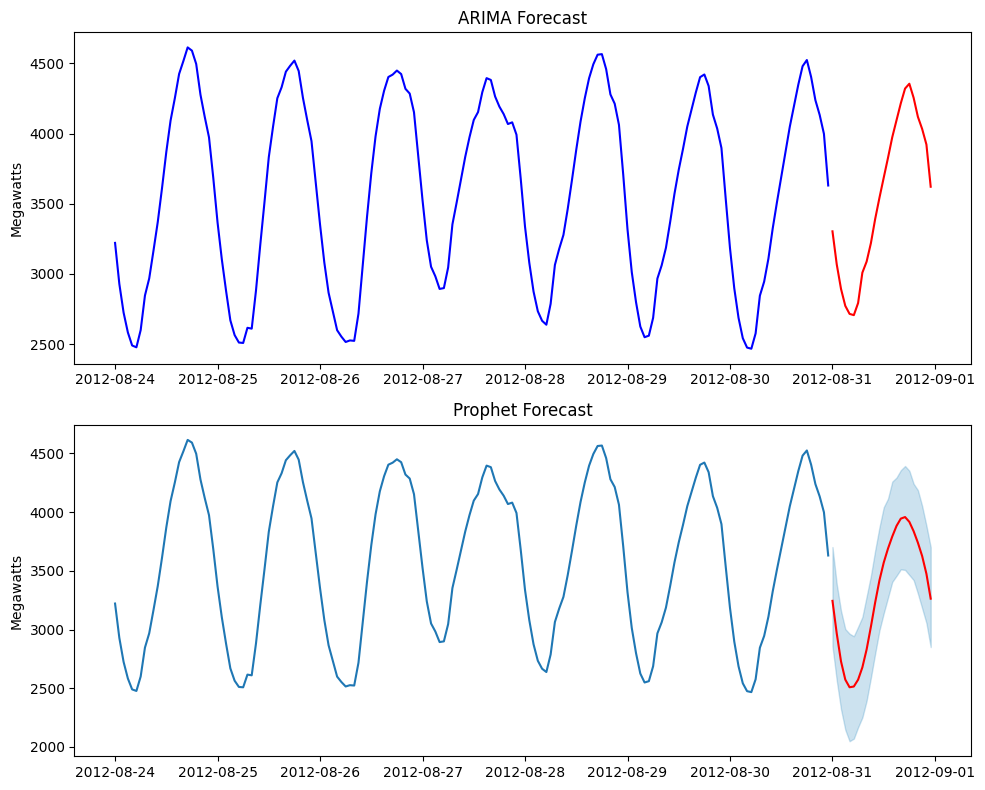

In [60]:
plt.figure(figsize=(10, 8))

# Arima Model
hist = df[-(24*7):].set_index("read_dt")

plt.subplot(211)
plt.plot(hist, c="blue")
plt.plot(forecasts, color='red', label='ARIMA Forecast')
plt.title('ARIMA Forecast')
plt.ylabel('Megawatts')

# Prophet Model
hist = ts[(-24*7):]
ds = pf[-24:]

plt.subplot(212)
plt.plot(hist.ds, hist.y)
plt.plot(ds.ds, ds.yhat, c='red')
plt.fill_between(ds.ds, ds.yhat_lower, ds.yhat_upper, color='#0072B2', alpha=0.2)
plt.title('Prophet Forecast')
plt.ylabel('Megawatts')

plt.tight_layout()
plt.show()


# FIN

Let me know what you think! Follow me at GitHub (https://www.github.com/bryangoodrich) or Threads (@bryangoodrich.xyz).